# Déterminer quel est le fichier donnant les meilleurs résultats  

* f"animal_faces_{80}x{80}px_carre_{False}_ct_{False}.pkl"
* f"animal_faces_{120}x{120}px_carre_{False}_ct_{False}.pkl"
* f"animal_faces_{80}x{80}px_carre_{True}_ct_{False}.pkl"
* f"animal_faces_{120}x{120}px_carre_{True}_ct_{False}.pkl"
* f"animal_faces_{80}x{80}px_carre_{False}_ct_{True}.pkl"
* f"animal_faces_{120}x{120}px_carre_{False}_ct_{True}.pkl"
* f"animal_faces_{80}x{80}px_carre_{True}_ct_{True}.pkl"
* f"animal_faces_{120}x{120}px_carre_{True}_ct_{True}.pkl"


In [5]:
import numpy as np
import pandas as pds

import joblib

import skimage
from skimage.io import imread
from skimage.feature import hog
from skimage.transform import rescale, resize
from skimage import data, color

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import cross_val_predict, GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt

import os 

import random

from collections import Counter


In [2]:
"""
On choisi l'un des fichiers générer plus haut.

fichier= f"animal_faces_{80}x{80}px_carre_{False}_ct_{False}.pkl"
fichier= f"animal_faces_{120}x{120}px_carre_{False}_ct_{False}.pkl"

fichier= f"animal_faces_{80}x{80}px_carre_{True}_ct_{False}.pkl"
fichier= f"animal_faces_{120}x{120}px_carre_{True}_ct_{False}.pkl"

fichier= f"animal_faces_{80}x{80}px_carre_{False}_ct_{True}.pkl"
fichier= f"animal_faces_{120}x{120}px_carre_{False}_ct_{True}.pkl"

fichier= f"animal_faces_{80}x{80}px_carre_{True}_ct_{True}.pkl"
fichier= f"animal_faces_{120}x{120}px_carre_{True}_ct_{True}.pkl"

"""

fichier= f"animal_faces_{80}x{80}px_carre_{False}_ct_{False}.pkl"

data = joblib.load(fichier)

# Problème de "Natural" libellé "Nat" à cause du "[:-4]" dans d_DATA['label'].append(el[:-4])
for i,el in enumerate(data["label"]):
    if el== "Nat":
        data["label"][i]= "Natural"


In [3]:
X = np.array(data['data'])
y = np.array(data['label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

In [4]:
"""

{'classify': SVC(kernel='linear'),
 'hogify__cells_per_block': (3, 3),
 'hogify__orientations': 8,
 'hogify__pixels_per_cell': (8, 8)}
"""

"\n\n{'classify': SVC(kernel='linear'),\n 'hogify__cells_per_block': (3, 3),\n 'hogify__orientations': 8,\n 'hogify__pixels_per_cell': (8, 8)}\n"

In [6]:
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [7]:
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(8,8), 
    cells_per_block=(3,2), 
    orientations=8, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(1905, 3456)


In [9]:
clf_SVC = svm.SVC(kernel='linear')
clf_SVC.fit(X_train_prepared, y_train)

SVC(kernel='linear')

In [12]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

In [13]:
y_pred = clf_SVC.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])

print('\nPercentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

[False False  True  True False  True False  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True]

Percentage correct:  79.45492662473795


In [14]:
print(classification_report(y_test, y_pred, target_names= np.unique(y_test)))

cmx = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

        Bear       0.76      0.76      0.76        21
         Cat       0.79      0.91      0.85        34
     Chicken       0.85      0.82      0.84        28
         Cow       0.75      0.72      0.73        25
        Deer       0.84      1.00      0.91        16
         Dog       0.74      0.81      0.78        81
        Duck       1.00      0.71      0.83        28
       Eagle       0.85      0.89      0.87        19
    Elephant       0.73      0.76      0.74        21
       Human       1.00      0.93      0.96        14
        Lion       0.58      0.85      0.69        13
      Monkey       0.76      0.81      0.79        16
       Mouse       0.78      0.74      0.76        19
     Natural       0.00      0.00      0.00         2
       Panda       0.90      0.86      0.88        22
         Pig       0.53      0.47      0.50        17
      Pigeon       0.83      0.88      0.86        17
      Rabbit       0.71    

/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 ['Bear', 'Cat', 'Chicken', 'Cow', 'Deer', 'Dog', 'Duck', 'Eagle', 'Elephant', 'Human', 'Lion', 'Monkey', 'Mouse', 'Natural', 'Panda', 'Pig', 'Pigeon', 'Rabbit', 'Sheep', 'Tiger', 'Wolf']


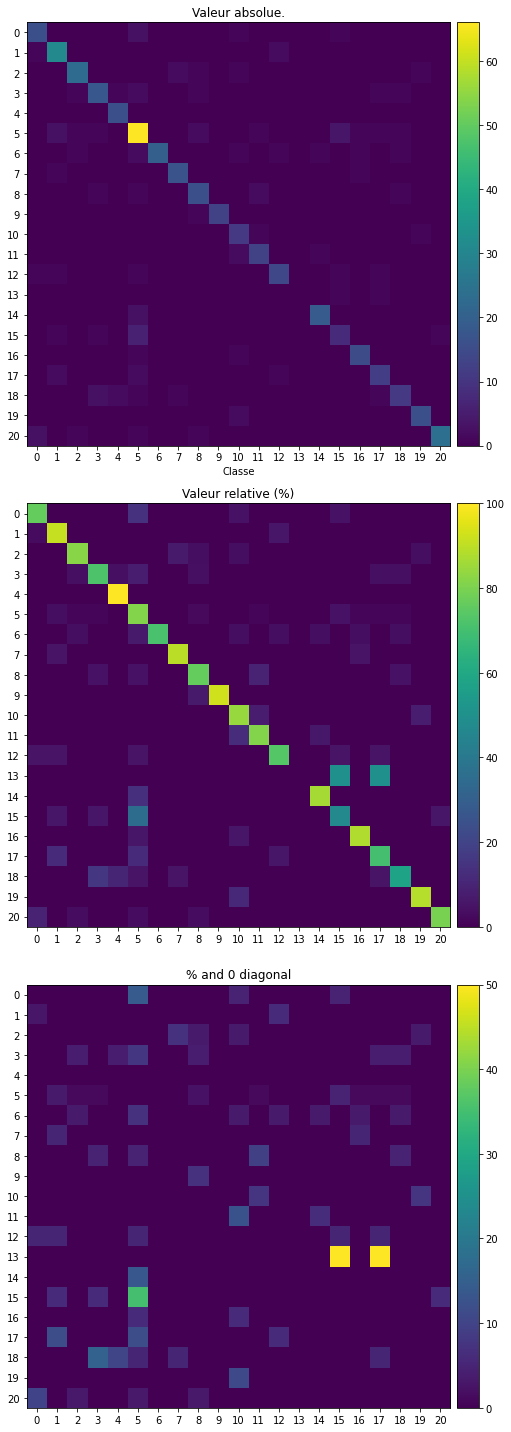

In [15]:
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(nrows=3)
    fig.set_size_inches(30, 20)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
    #for a in ax:print(a) # c'est quoi les valeur de a ????
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('Valeur absolue.')
    ax[0].set_xlabel("Classe")
    
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('Valeur relative (%)')
    
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))